# Action Graph 

### Goals:

- A graph store/database to store and trace any computations during eager execution
- Graph that works with the current in memory worker
- Ability to visualize the graph
- Generate a dependecy list of node, so that any dependeny action can be generated
- Basic query/search functionalities
- Locking/Concurrency

In [1]:
import syft as sy
from syft.service.action.action_graph_service import ActionGraphService, NodeActionDataUpdate, ExecutionStatus
from syft.service.action.action_graph import InMemoryActionGraphStore, InMemoryGraphConfig, InMemoryStoreClientConfig

from syft.service.context import AuthedServiceContext
from syft.node.credentials import SyftSigningKey
from syft.service.action.action_graph import Action
from syft.service.action.numpy import NumpyArrayObject, ActionObject
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /home/shubham/PySyft


## Scenario for performing some computation

```python

import syft as sy

domain_client = sy.login("....")

dataset = domain_client.datasets[0]

a = dataset.assets["A"]

b = dataset.assets["B"]

c = a + b

d = domain_client.api.numpy.array([1, 2, 3])

e = c * d

# Inplace operation, mutated the value of d
d.astype('int32')

d[2] = 5

f = d + 48
```

<br>
<br>

**Corresponding Actions Generated**

```

action1 -> a + b

action2 -> initialization of variable `d`

action3 -> c * d

action4 -> inplace updation of type of `d` (d.astype('int32'))

action5 -> d[2] = 5

action6 -> d + 48

```

![graph.png](graph.png)

### Initializing the Store

In [2]:
# Create a Config

store_config = InMemoryGraphConfig()

In [3]:
# Initialize the InMemory Store

graph_store = InMemoryActionGraphStore(store_config=store_config)

In [4]:
G = graph_store.graph.db

### Initializing Action Graph Service

In [5]:
action_graph_service = ActionGraphService(store=graph_store)

In [6]:
signing_key = SyftSigningKey.generate()
authed_context = AuthedServiceContext(credentials=signing_key.verify_key)

In [7]:
signing_key = SyftSigningKey.generate()
authed_context = AuthedServiceContext(credentials=signing_key.verify_key)

### Create some dummy data

In [8]:
labels_dict = {}

In [9]:
action_obj_a = ActionObject.from_obj([2, 4, 6])
action_obj_b = ActionObject.from_obj([2, 3, 4])

In [10]:
labels_dict[action_obj_a.id] = "A"
labels_dict[action_obj_b.id] = "B"

In [11]:
action_obj_a.id, action_obj_b.id

(<UID: 74f8266dbb2944cfa7c4d8d0caecbcb2>,
 <UID: 9f5f1d3e39f4410b9d970a8183894a72>)

In [12]:
action_graph_service.add_action_obj(context=authed_context, action_obj=action_obj_a)

```python
class NodeActionData:
  id: str = 74f8266dbb2944cfa7c4d8d0caecbcb2
  type: str = NodeType.ACTION_OBJECT
  status: str = ExecutionStatus.PROCESSING
  retry: str = 0
  created_at: str = 2023-05-04 01:02:27
  updated_at: str = None
  user_verify_key: str = dfa02c919cc89052a039275b67a616e712cb11413e5e422e81147af7aedfabdd
  is_mutated: str = False
  is_mutagen: str = False
  next_mutagen_node: str = None
  last_nm_mutagen_node: str = None

```

In [13]:
action_graph_service.add_action_obj(context=authed_context, action_obj=action_obj_b)

```python
class NodeActionData:
  id: str = 9f5f1d3e39f4410b9d970a8183894a72
  type: str = NodeType.ACTION_OBJECT
  status: str = ExecutionStatus.PROCESSING
  retry: str = 0
  created_at: str = 2023-05-04 01:02:27
  updated_at: str = None
  user_verify_key: str = dfa02c919cc89052a039275b67a616e712cb11413e5e422e81147af7aedfabdd
  is_mutated: str = False
  is_mutagen: str = False
  next_mutagen_node: str = None
  last_nm_mutagen_node: str = None

```

### Action1 -> A + B

In [14]:
action1 = Action(
    path="action.execute",
    op="__add__",
    remote_self=action_obj_a.syft_lineage_id,
    args=[action_obj_b.syft_lineage_id],
    kwargs={}
)
action1

```python
class Action:
  id: str = d5d63ab2462a48798ec78619fef09f08
  path: str = "action.execute"
  op: str = "__add__"
  remote_self: str = 74f8266dbb2944cfa7c4d8d0caecbcb2
  args: str = [<LineageID: 9f5f1d3e39f4410b9d970a8183894a72 - 1769901954733658870>]
  kwargs: str = {}
  result_id: str = 32e2455510374439bb61424561062966

```

In [15]:
labels_dict[action1.id] = "+"
labels_dict[action1.result_id.id] = "C"

### Save action to Graph

In [16]:
# action_graph_service.add_action

In [17]:
action_graph_service.add_action(context=authed_context, action=action1)

(class NodeActionData:
   id: str = d5d63ab2462a48798ec78619fef09f08
   type: str = NodeType.ACTION
   status: str = ExecutionStatus.PROCESSING
   retry: str = 0
   created_at: str = 2023-05-04 01:02:28
   updated_at: str = None
   user_verify_key: str = dfa02c919cc89052a039275b67a616e712cb11413e5e422e81147af7aedfabdd
   is_mutated: str = False
   is_mutagen: str = False
   next_mutagen_node: str = None
   last_nm_mutagen_node: str = None,
 class NodeActionData:
   id: str = 32e2455510374439bb61424561062966
   type: str = NodeType.ACTION_OBJECT
   status: str = ExecutionStatus.PROCESSING
   retry: str = 0
   created_at: str = 2023-05-04 01:02:28
   updated_at: str = None
   user_verify_key: str = dfa02c919cc89052a039275b67a616e712cb11413e5e422e81147af7aedfabdd
   is_mutated: str = False
   is_mutagen: str = False
   next_mutagen_node: str = None
   last_nm_mutagen_node: str = None)

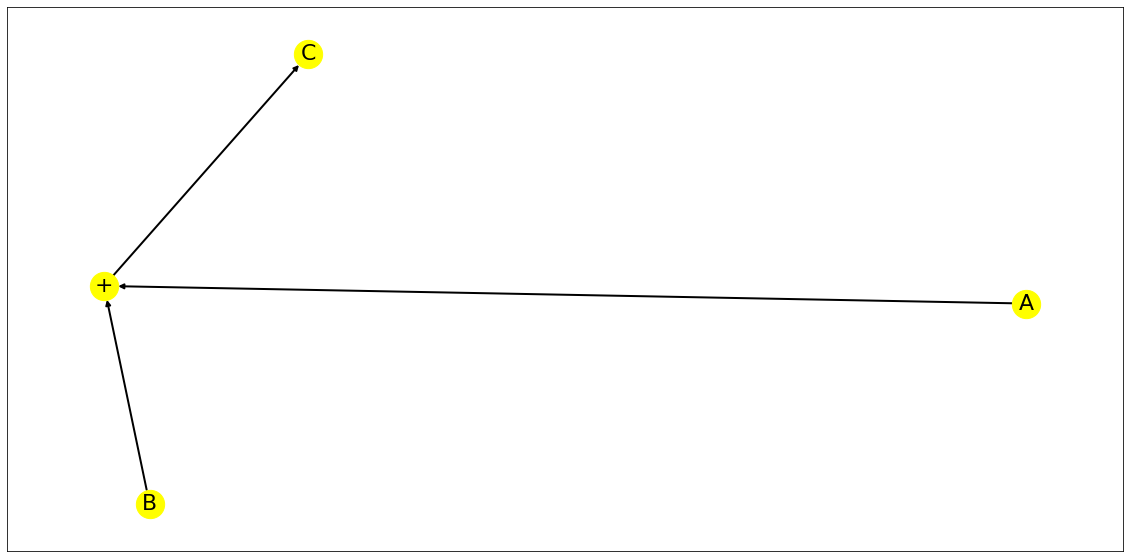

In [18]:
plt.figure(figsize=(20, 10))
pos = nx.spring_layout(G, seed=3113794652)
# nx.draw_networkx_nodes(G, pos=pos)
nx.draw_networkx(G, pos=pos, labels=labels_dict, with_labels=True, width=2.0, node_color="yellow", node_size=800, font_size=22)

### Action2 -> np.array([1, 2, 3])

In [19]:
action_obj_d = ActionObject.from_obj([1, 2, 3])

In [20]:
labels_dict[action_obj_d.id] = "[1, 2 ,3]"

In [21]:
action_graph_service.add_action_obj(context=authed_context, action_obj=action_obj_d)

```python
class NodeActionData:
  id: str = dc0e49bd4b764583a827ffc198d140cf
  type: str = NodeType.ACTION_OBJECT
  status: str = ExecutionStatus.PROCESSING
  retry: str = 0
  created_at: str = 2023-05-04 01:02:30
  updated_at: str = None
  user_verify_key: str = dfa02c919cc89052a039275b67a616e712cb11413e5e422e81147af7aedfabdd
  is_mutated: str = False
  is_mutagen: str = False
  next_mutagen_node: str = None
  last_nm_mutagen_node: str = None

```

In [22]:
# Create Action2

action2 = Action(
    path="action.execute",
    op="np.array",
    remote_self=None,
    args=[action_obj_d.syft_lineage_id],
    kwargs={}
)
action2

```python
class Action:
  id: str = 5e040210d85b402696a6d082517401c7
  path: str = "action.execute"
  op: str = "np.array"
  remote_self: str = None
  args: str = [<LineageID: dc0e49bd4b764583a827ffc198d140cf - 619893299653864739>]
  kwargs: str = {}
  result_id: str = f6be7504daea4706b21dd926da245d6d

```

In [23]:
labels_dict[action2.id] = "np.array"
labels_dict[action2.result_id.id] = "D"

In [24]:
# Save action to graph
action_graph_service.add_action(context=authed_context, action=action2)

(class NodeActionData:
   id: str = 5e040210d85b402696a6d082517401c7
   type: str = NodeType.ACTION
   status: str = ExecutionStatus.PROCESSING
   retry: str = 0
   created_at: str = 2023-05-04 01:02:31
   updated_at: str = None
   user_verify_key: str = dfa02c919cc89052a039275b67a616e712cb11413e5e422e81147af7aedfabdd
   is_mutated: str = False
   is_mutagen: str = False
   next_mutagen_node: str = None
   last_nm_mutagen_node: str = None,
 class NodeActionData:
   id: str = f6be7504daea4706b21dd926da245d6d
   type: str = NodeType.ACTION_OBJECT
   status: str = ExecutionStatus.PROCESSING
   retry: str = 0
   created_at: str = 2023-05-04 01:02:31
   updated_at: str = None
   user_verify_key: str = dfa02c919cc89052a039275b67a616e712cb11413e5e422e81147af7aedfabdd
   is_mutated: str = False
   is_mutagen: str = False
   next_mutagen_node: str = None
   last_nm_mutagen_node: str = None)

In [25]:
# 747749f9494345b78e165f13351e52bf: {"data": NodeActionData()}

In [26]:
action1.result_id.id

<UID: 32e2455510374439bb61424561062966>

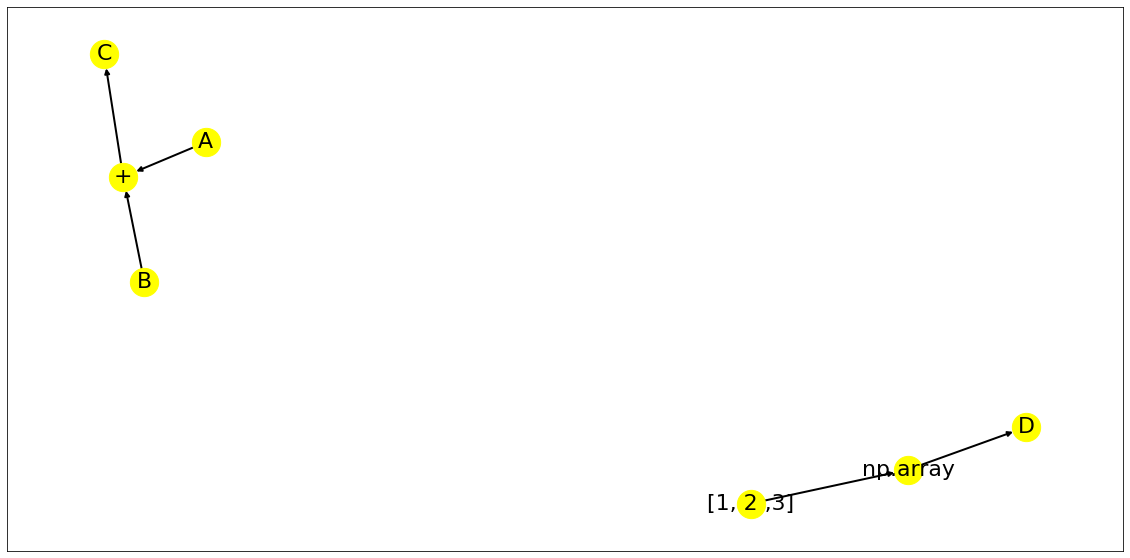

In [27]:
plt.figure(figsize=(20, 10))
pos = nx.spring_layout(G, seed=3113794652)
# nx.draw_networkx_nodes(G, pos=pos)
nx.draw_networkx(G, pos=pos, labels=labels_dict, with_labels=True, width=2.0, node_color="yellow", node_size=800, font_size=22)

### Action3 -> C * D

In [28]:
action3 = Action(
    path="action.execute",
    op="__mul__",
    remote_self=action1.result_id,
    args=[action2.result_id],
    kwargs={}
)
action3

```python
class Action:
  id: str = 635b9105fd2445f182eb18e4561d7d93
  path: str = "action.execute"
  op: str = "__mul__"
  remote_self: str = 32e2455510374439bb61424561062966
  args: str = [<LineageID: f6be7504daea4706b21dd926da245d6d - 581387997597308384>]
  kwargs: str = {}
  result_id: str = 3c29cbdbd4474db68e36131bfb406847

```

In [29]:
action_graph_service.add_action(context=authed_context, action=action3)

(class NodeActionData:
   id: str = 635b9105fd2445f182eb18e4561d7d93
   type: str = NodeType.ACTION
   status: str = ExecutionStatus.PROCESSING
   retry: str = 0
   created_at: str = 2023-05-04 01:02:35
   updated_at: str = None
   user_verify_key: str = dfa02c919cc89052a039275b67a616e712cb11413e5e422e81147af7aedfabdd
   is_mutated: str = False
   is_mutagen: str = False
   next_mutagen_node: str = None
   last_nm_mutagen_node: str = None,
 class NodeActionData:
   id: str = 3c29cbdbd4474db68e36131bfb406847
   type: str = NodeType.ACTION_OBJECT
   status: str = ExecutionStatus.PROCESSING
   retry: str = 0
   created_at: str = 2023-05-04 01:02:35
   updated_at: str = None
   user_verify_key: str = dfa02c919cc89052a039275b67a616e712cb11413e5e422e81147af7aedfabdd
   is_mutated: str = False
   is_mutagen: str = False
   next_mutagen_node: str = None
   last_nm_mutagen_node: str = None)

In [30]:
labels_dict[action3.id] = "*"
labels_dict[action3.result_id.id] = "E"

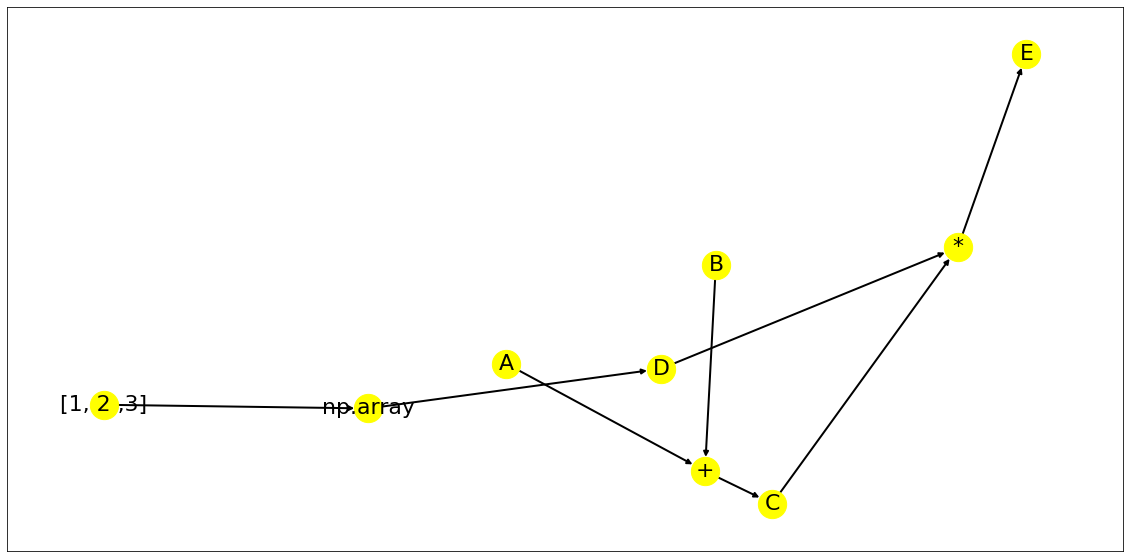

In [31]:
plt.figure(figsize=(20, 10))
pos = nx.spring_layout(G, seed=3113794651)
# nx.draw_networkx_nodes(G, pos=pos)
nx.draw_networkx(G, pos=pos, labels=labels_dict, with_labels=True, width=2.0, node_color="yellow", node_size=800, font_size=22)

### Action4 -> Mutate type of D

In [32]:
as_type_action_obj = ActionObject.from_obj('np.int32')

In [33]:
action_graph_service.add_action_obj(context=authed_context, action_obj=as_type_action_obj)

```python
class NodeActionData:
  id: str = b18b809c3a2241c094043fd84e9d6eee
  type: str = NodeType.ACTION_OBJECT
  status: str = ExecutionStatus.PROCESSING
  retry: str = 0
  created_at: str = 2023-05-04 01:02:38
  updated_at: str = None
  user_verify_key: str = dfa02c919cc89052a039275b67a616e712cb11413e5e422e81147af7aedfabdd
  is_mutated: str = False
  is_mutagen: str = False
  next_mutagen_node: str = None
  last_nm_mutagen_node: str = None

```

In [34]:
labels_dict[as_type_action_obj.id] = "np.int32"

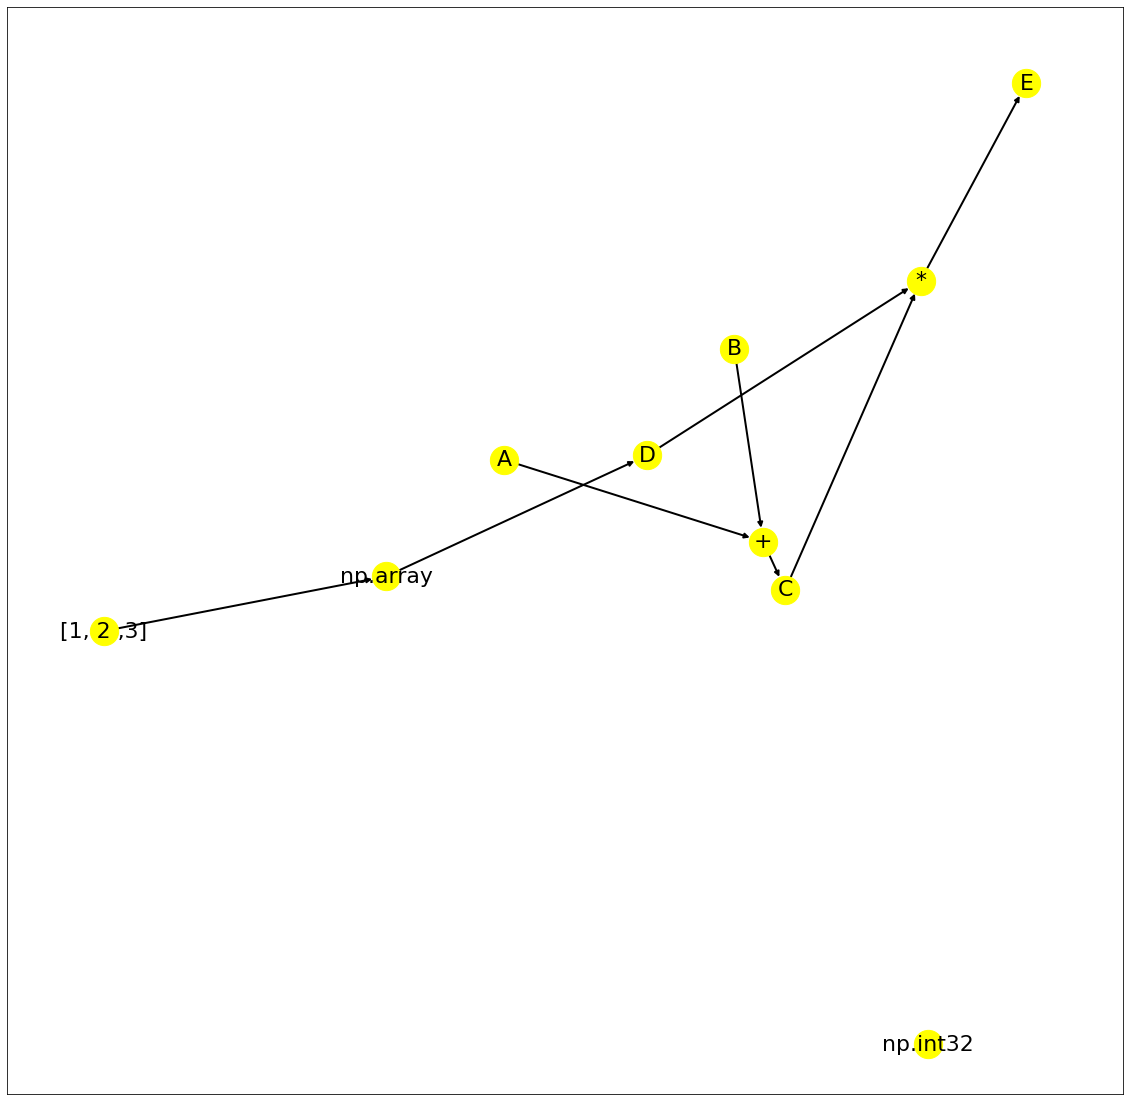

In [35]:
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(G, seed=3113794651)
# nx.draw_networkx_nodes(G, pos=pos)
nx.draw_networkx(G, pos=pos, labels=labels_dict, with_labels=True, width=2.0, node_color="yellow", node_size=800, font_size=22)

In [36]:
action4 = Action(
    path="action.execute",
    op="astype",
    remote_self=action2.result_id,
    args=[as_type_action_obj.syft_lineage_id],
    kwargs={},
    result_id=action2.result_id
)
action4

```python
class Action:
  id: str = 3cdefe1749ba4002ba5dc32f74e2fb0f
  path: str = "action.execute"
  op: str = "astype"
  remote_self: str = f6be7504daea4706b21dd926da245d6d
  args: str = [<LineageID: b18b809c3a2241c094043fd84e9d6eee - 27097163950423327>]
  kwargs: str = {}
  result_id: str = f6be7504daea4706b21dd926da245d6d

```

In [37]:
action_graph_service.add_action(context=authed_context, action=action4)

(class NodeActionData:
   id: str = 3cdefe1749ba4002ba5dc32f74e2fb0f
   type: str = NodeType.ACTION
   status: str = ExecutionStatus.PROCESSING
   retry: str = 0
   created_at: str = 2023-05-04 01:02:40
   updated_at: str = None
   user_verify_key: str = dfa02c919cc89052a039275b67a616e712cb11413e5e422e81147af7aedfabdd
   is_mutated: str = False
   is_mutagen: str = True
   next_mutagen_node: str = None
   last_nm_mutagen_node: str = None,
 class NodeActionData:
   id: str = None
   type: str = NodeType.ACTION_OBJECT
   status: str = ExecutionStatus.PROCESSING
   retry: str = 0
   created_at: str = 2023-05-04 01:02:31
   updated_at: str = 2023-05-04 01:02:40
   user_verify_key: str = dfa02c919cc89052a039275b67a616e712cb11413e5e422e81147af7aedfabdd
   is_mutated: str = True
   is_mutagen: str = False
   next_mutagen_node: str = 3cdefe1749ba4002ba5dc32f74e2fb0f
   last_nm_mutagen_node: str = 3cdefe1749ba4002ba5dc32f74e2fb0f)

In [38]:
labels_dict[action4.id] = "astype"

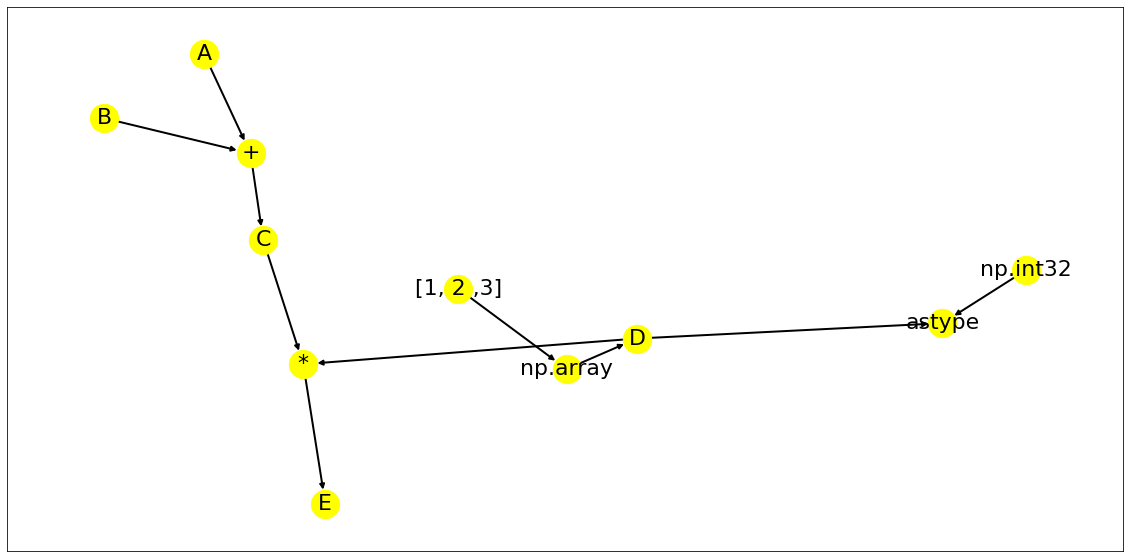

In [39]:
plt.figure(figsize=(20, 10))
pos = nx.spring_layout(G, seed=3113794652)
# nx.draw_networkx_nodes(G, pos=pos)
nx.draw_networkx(G, pos=pos, labels=labels_dict, with_labels=True, width=2.0, node_color="yellow", node_size=800, font_size=22)

In [40]:
mid = G.nodes(data=True)[action2.result_id.id]["data"]['next_mutagen_node']
mid

<UID: 3cdefe1749ba4002ba5dc32f74e2fb0f>

In [41]:
G.nodes(data=True)[action2.result_id.id]['data']

```python
class NodeActionData:
  id: str = None
  type: str = NodeType.ACTION_OBJECT
  status: str = ExecutionStatus.PROCESSING
  retry: str = 0
  created_at: str = 2023-05-04 01:02:31
  updated_at: str = 2023-05-04 01:02:40
  user_verify_key: str = dfa02c919cc89052a039275b67a616e712cb11413e5e422e81147af7aedfabdd
  is_mutated: str = True
  is_mutagen: str = False
  next_mutagen_node: str = 3cdefe1749ba4002ba5dc32f74e2fb0f
  last_nm_mutagen_node: str = 3cdefe1749ba4002ba5dc32f74e2fb0f

```

In [42]:
G.nodes(data=True)[mid]['data'].id == action4.id

True

In [43]:
G.nodes(data=True)[action4.id]['data']

```python
class NodeActionData:
  id: str = 3cdefe1749ba4002ba5dc32f74e2fb0f
  type: str = NodeType.ACTION
  status: str = ExecutionStatus.PROCESSING
  retry: str = 0
  created_at: str = 2023-05-04 01:02:40
  updated_at: str = None
  user_verify_key: str = dfa02c919cc89052a039275b67a616e712cb11413e5e422e81147af7aedfabdd
  is_mutated: str = False
  is_mutagen: str = True
  next_mutagen_node: str = None
  last_nm_mutagen_node: str = None

```

#### Action5 -> D[0] = 10

In [44]:
idx_action_obj = ActionObject.from_obj(2)
action_graph_service.add_action_obj(context=authed_context, action_obj=idx_action_obj)

```python
class NodeActionData:
  id: str = 4f885938e1a643f08704e2e33cc80d2e
  type: str = NodeType.ACTION_OBJECT
  status: str = ExecutionStatus.PROCESSING
  retry: str = 0
  created_at: str = 2023-05-04 01:02:44
  updated_at: str = None
  user_verify_key: str = dfa02c919cc89052a039275b67a616e712cb11413e5e422e81147af7aedfabdd
  is_mutated: str = False
  is_mutagen: str = False
  next_mutagen_node: str = None
  last_nm_mutagen_node: str = None

```

In [45]:
labels_dict[idx_action_obj.id] = "2"

In [46]:
item_val_action_obj = ActionObject.from_obj(5)
action_graph_service.add_action_obj(context=authed_context, action_obj=item_val_action_obj)

```python
class NodeActionData:
  id: str = f84a148f90b5464bb1ec12fab2e42c6e
  type: str = NodeType.ACTION_OBJECT
  status: str = ExecutionStatus.PROCESSING
  retry: str = 0
  created_at: str = 2023-05-04 01:02:45
  updated_at: str = None
  user_verify_key: str = dfa02c919cc89052a039275b67a616e712cb11413e5e422e81147af7aedfabdd
  is_mutated: str = False
  is_mutagen: str = False
  next_mutagen_node: str = None
  last_nm_mutagen_node: str = None

```

In [47]:
labels_dict[item_val_action_obj.id] = "5"

In [48]:
action5 = Action(
    path="action.execute",
    op="__setitem__",
    remote_self=action2.result_id,
    args=[idx_action_obj.syft_lineage_id, item_val_action_obj.syft_lineage_id],
    kwargs={},
    result_id=action2.result_id
)
action5

```python
class Action:
  id: str = 77f63baa19184d56b7d301dda494f07b
  path: str = "action.execute"
  op: str = "__setitem__"
  remote_self: str = f6be7504daea4706b21dd926da245d6d
  args: str = [<LineageID: 4f885938e1a643f08704e2e33cc80d2e - 236347352845790406>, <LineageID: f84a148f90b5464bb1ec12fab2e42c6e - 1458242102039043849>]
  kwargs: str = {}
  result_id: str = f6be7504daea4706b21dd926da245d6d

```

In [49]:
action_graph_service.add_action(context=authed_context, action=action5)

(class NodeActionData:
   id: str = 77f63baa19184d56b7d301dda494f07b
   type: str = NodeType.ACTION
   status: str = ExecutionStatus.PROCESSING
   retry: str = 0
   created_at: str = 2023-05-04 01:02:46
   updated_at: str = None
   user_verify_key: str = dfa02c919cc89052a039275b67a616e712cb11413e5e422e81147af7aedfabdd
   is_mutated: str = False
   is_mutagen: str = True
   next_mutagen_node: str = None
   last_nm_mutagen_node: str = None,
 class NodeActionData:
   id: str = None
   type: str = NodeType.ACTION
   status: str = ExecutionStatus.PROCESSING
   retry: str = 0
   created_at: str = 2023-05-04 01:02:40
   updated_at: str = 2023-05-04 01:02:46
   user_verify_key: str = dfa02c919cc89052a039275b67a616e712cb11413e5e422e81147af7aedfabdd
   is_mutated: str = True
   is_mutagen: str = True
   next_mutagen_node: str = 77f63baa19184d56b7d301dda494f07b
   last_nm_mutagen_node: str = 77f63baa19184d56b7d301dda494f07b)

In [50]:
labels_dict[action5.id] = "__setitem__"

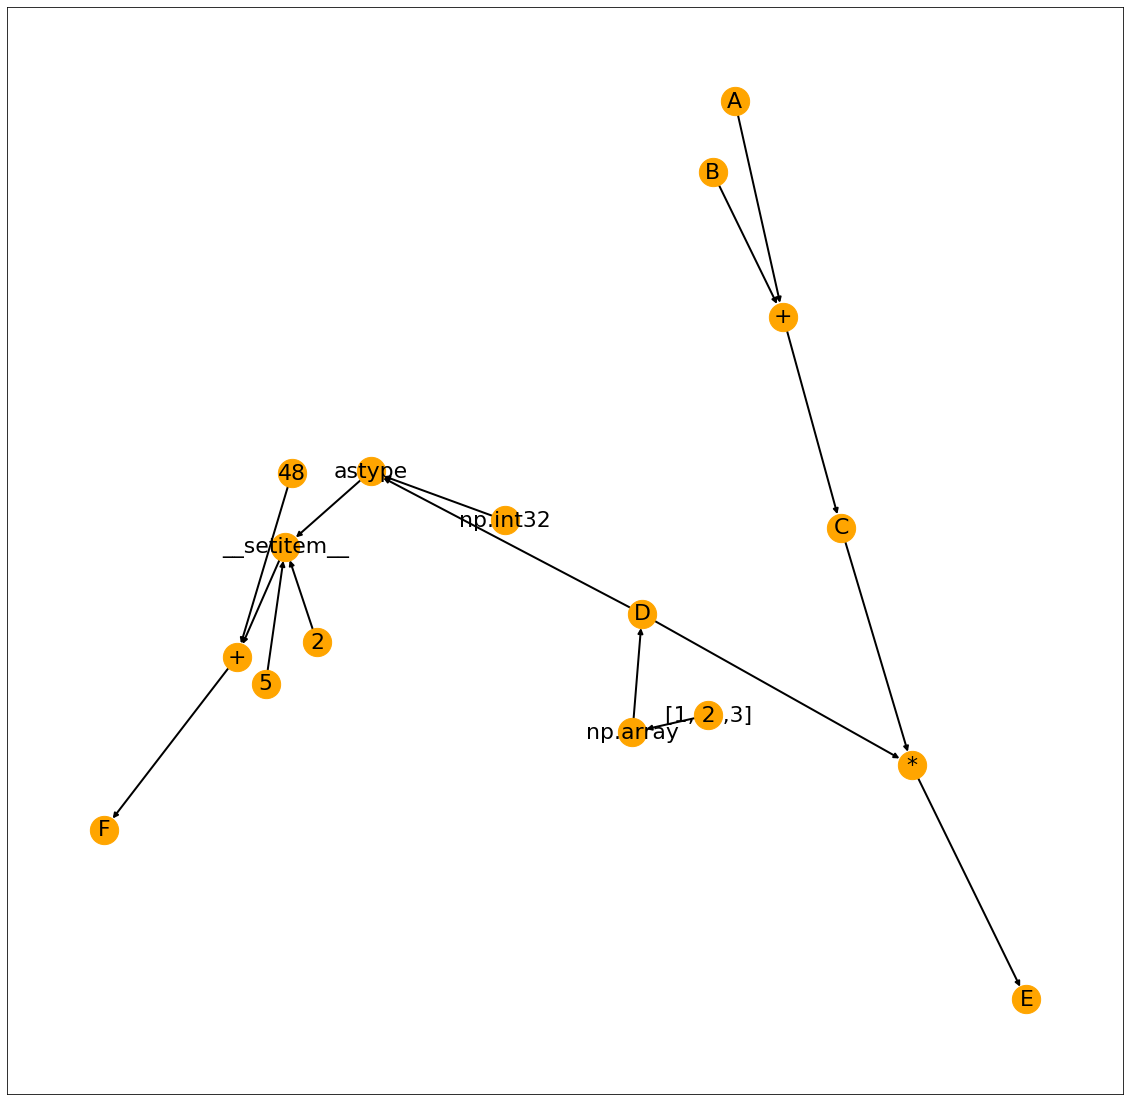

In [115]:
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(G, seed=3113794652)
# nx.draw_networkx_nodes(G, pos=pos)
nx.draw_networkx(G, pos=pos, labels=labels_dict, with_labels=True, width=2.0, node_color="orange", node_size=800, font_size=22)


### Action6 -> D + 48

In [52]:
arg_action_obj = ActionObject.from_obj(48)

In [53]:
action_graph_service.add_action_obj(context=authed_context, action_obj=arg_action_obj)

```python
class NodeActionData:
  id: str = 6670c4dcda7c49ce96c1c1587b19cb1d
  type: str = NodeType.ACTION_OBJECT
  status: str = ExecutionStatus.PROCESSING
  retry: str = 0
  created_at: str = 2023-05-04 01:02:49
  updated_at: str = None
  user_verify_key: str = dfa02c919cc89052a039275b67a616e712cb11413e5e422e81147af7aedfabdd
  is_mutated: str = False
  is_mutagen: str = False
  next_mutagen_node: str = None
  last_nm_mutagen_node: str = None

```

In [54]:
labels_dict[arg_action_obj.id] = "48"

In [55]:
action6 = Action(
    path="action.execute",
    op="__add__",
    remote_self=action2.result_id,
    args=[arg_action_obj.syft_lineage_id],
    kwargs={},
)
action6

```python
class Action:
  id: str = d93f0c7d14244d4cb1ed2ee782449cad
  path: str = "action.execute"
  op: str = "__add__"
  remote_self: str = f6be7504daea4706b21dd926da245d6d
  args: str = [<LineageID: 6670c4dcda7c49ce96c1c1587b19cb1d - 740816022331464107>]
  kwargs: str = {}
  result_id: str = 3e85848b139e47cf8c86aa1663646b3a

```

In [56]:
action_graph_service.add_action(context=authed_context, action=action6)

(class NodeActionData:
   id: str = d93f0c7d14244d4cb1ed2ee782449cad
   type: str = NodeType.ACTION
   status: str = ExecutionStatus.PROCESSING
   retry: str = 0
   created_at: str = 2023-05-04 01:02:50
   updated_at: str = None
   user_verify_key: str = dfa02c919cc89052a039275b67a616e712cb11413e5e422e81147af7aedfabdd
   is_mutated: str = False
   is_mutagen: str = False
   next_mutagen_node: str = None
   last_nm_mutagen_node: str = None,
 class NodeActionData:
   id: str = 3e85848b139e47cf8c86aa1663646b3a
   type: str = NodeType.ACTION_OBJECT
   status: str = ExecutionStatus.PROCESSING
   retry: str = 0
   created_at: str = 2023-05-04 01:02:50
   updated_at: str = None
   user_verify_key: str = dfa02c919cc89052a039275b67a616e712cb11413e5e422e81147af7aedfabdd
   is_mutated: str = False
   is_mutagen: str = False
   next_mutagen_node: str = None
   last_nm_mutagen_node: str = None)

In [57]:
labels_dict[action6.id] = "+"
labels_dict[action6.result_id.id] = "F"

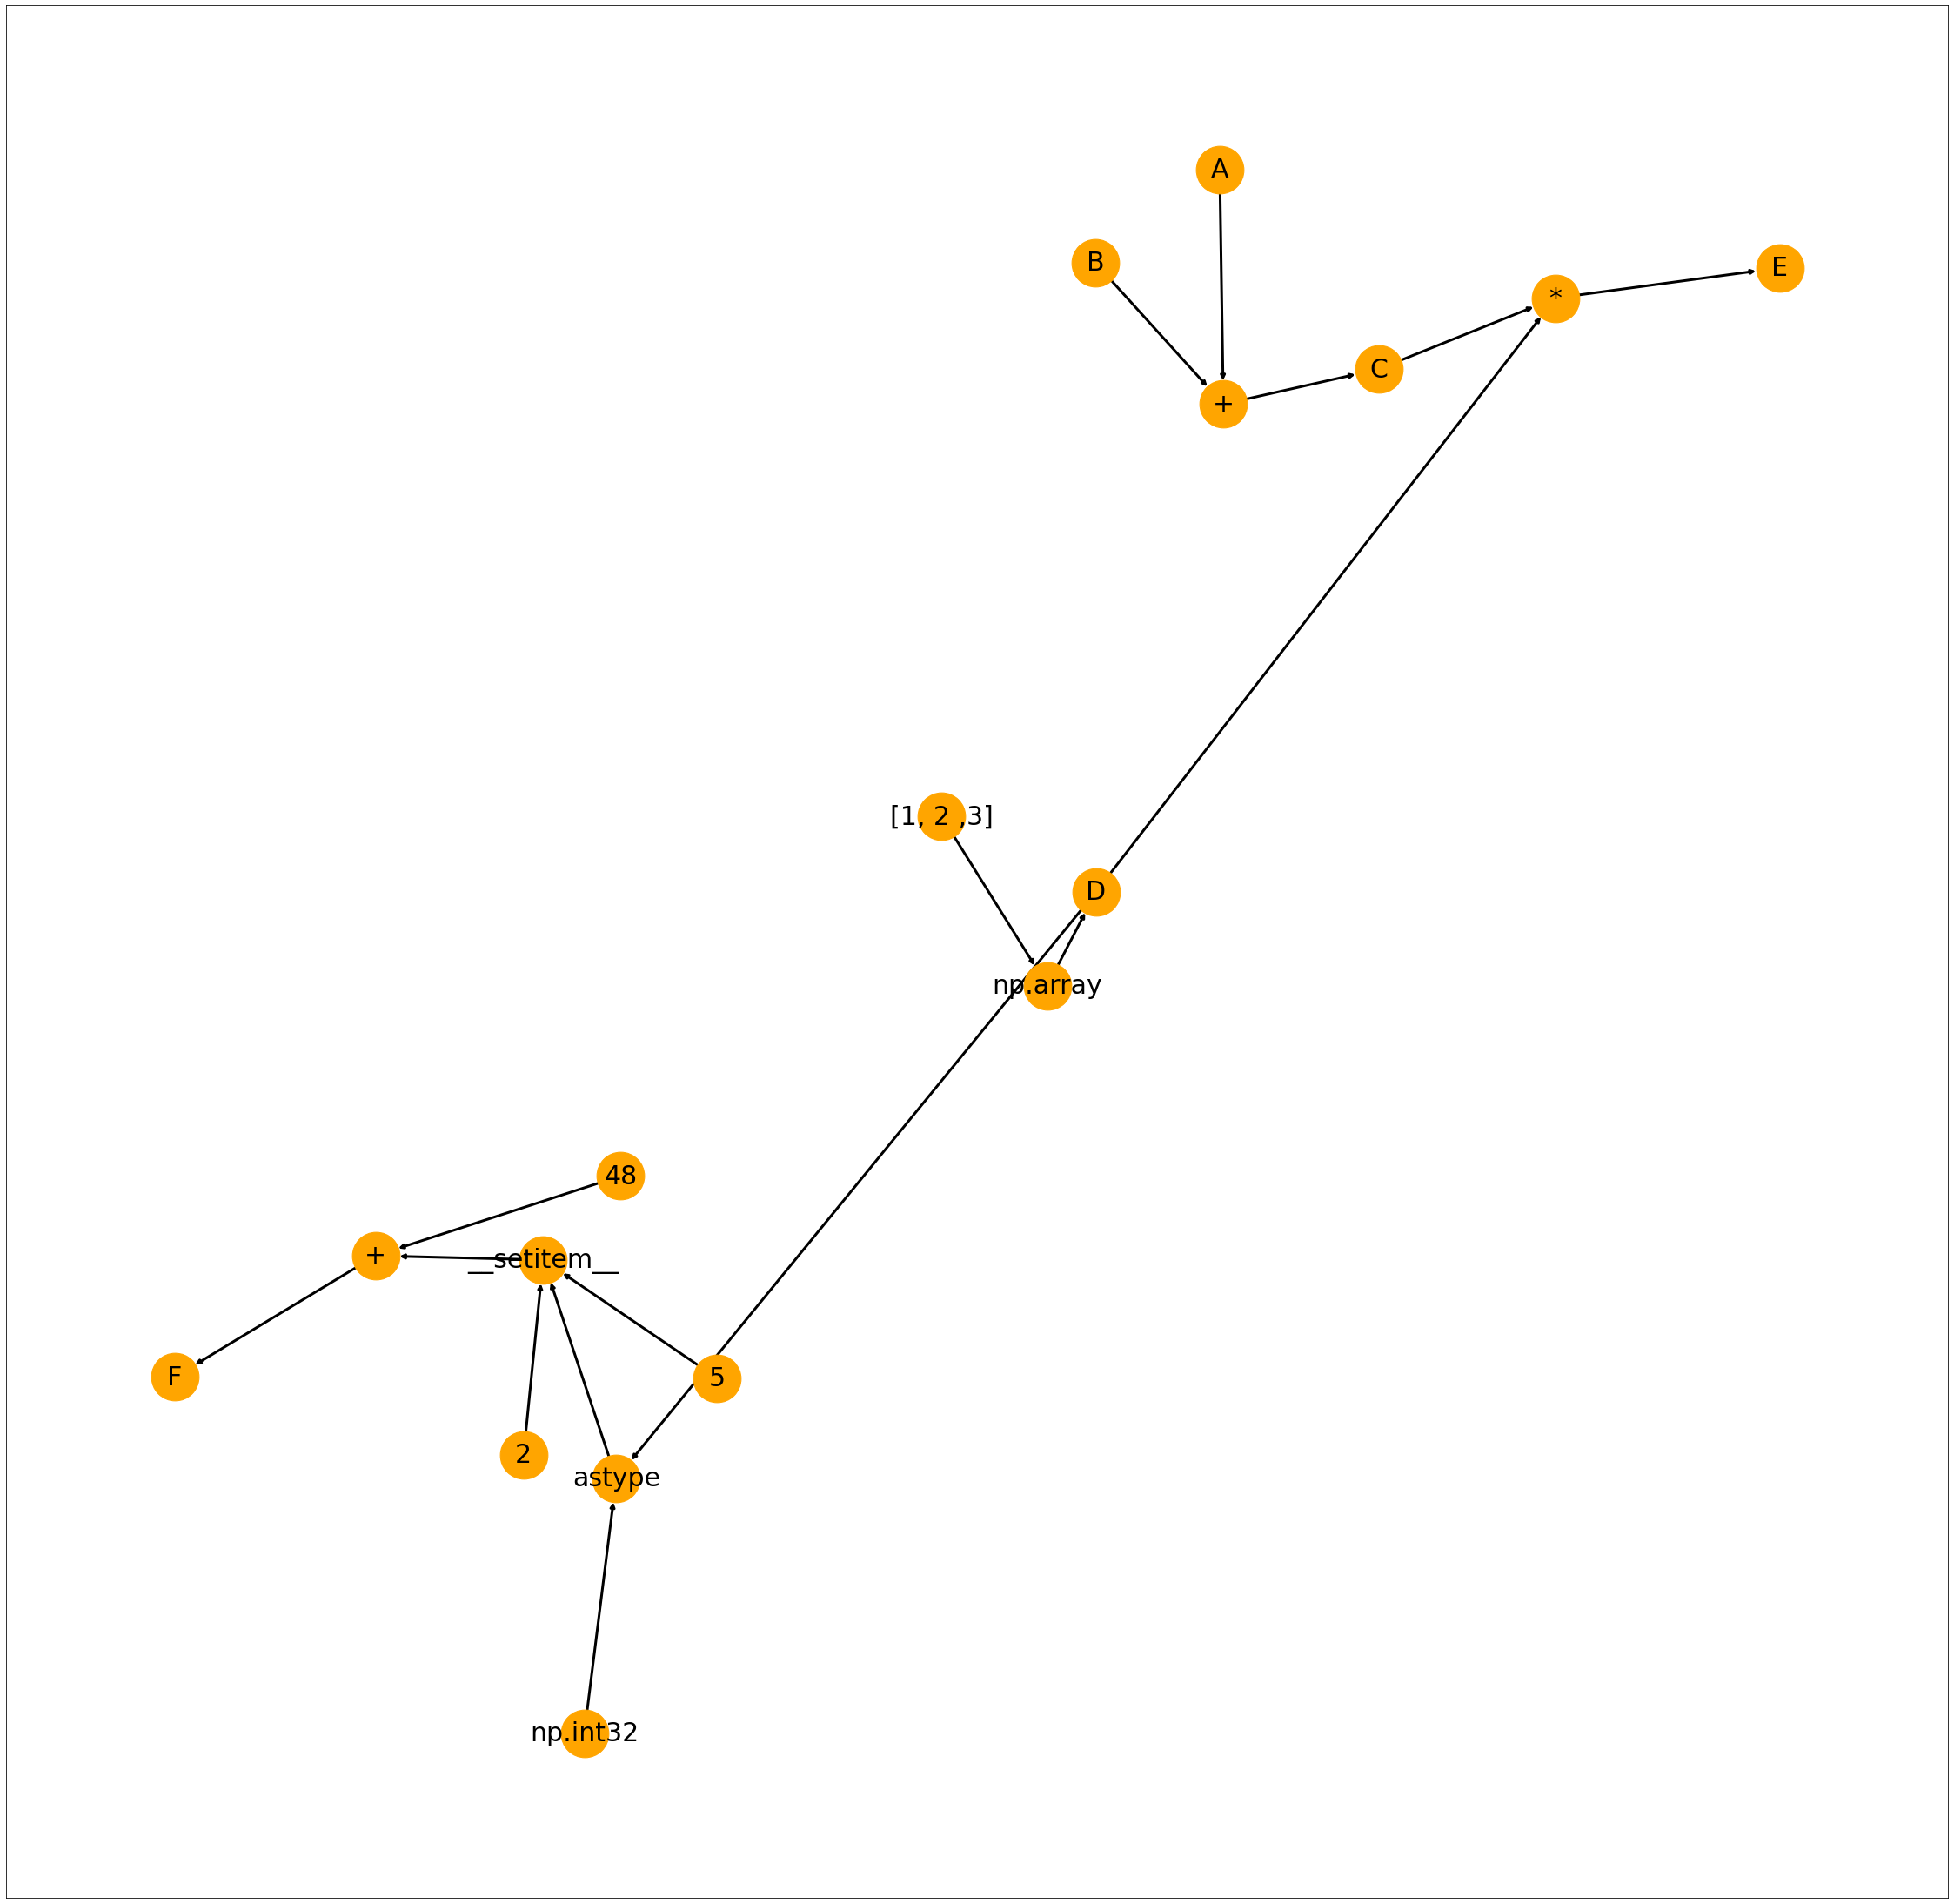

In [72]:
plt.figure(figsize=(40, 40))
pos = nx.spring_layout(G)
# nx.draw_networkx_nodes(G, pos=pos)
nx.draw_networkx(G, pos=pos, labels=labels_dict, with_labels=True, width=3.0, node_color="orange", node_size=3000, font_size=30)

In [59]:
labels_dict.values()

dict_values(['A', 'B', '+', 'C', '[1, 2 ,3]', 'np.array', 'D', '*', 'E', 'np.int32', 'astype', '2', '5', '__setitem__', '48', '+', 'F'])

```

action1 -> a + b

action2 -> initialization of variable `d`

action3 -> c * d

action4 -> inplace updation of type of `d` (d.astype('int32'))

action5 -> d[0] = 10

action6 -> d + 48

```

## Filtering Actions in the Graph

### Filter by ExecutionStatus

```
ExecutionStatus
- PROCESSING
- DONE
- FAILED
```

In [73]:
action_graph_service.get_by_action_status(context=authed_context, status=ExecutionStatus.PROCESSING)

,type,id
0,<UID: 74f8266dbb2944cfa7c4d8d0caecbcb2>,74f8266dbb2944cfa7c4d8d0caecbcb2
1,<UID: 9f5f1d3e39f4410b9d970a8183894a72>,9f5f1d3e39f4410b9d970a8183894a72
2,<UID: dc0e49bd4b764583a827ffc198d140cf>,dc0e49bd4b764583a827ffc198d140cf
3,<UID: b18b809c3a2241c094043fd84e9d6eee>,b18b809c3a2241c094043fd84e9d6eee
4,<UID: 4f885938e1a643f08704e2e33cc80d2e>,4f885938e1a643f08704e2e33cc80d2e


In [116]:
action1

```python
class Action:
  id: str = d5d63ab2462a48798ec78619fef09f08
  path: str = "action.execute"
  op: str = "__add__"
  remote_self: str = 74f8266dbb2944cfa7c4d8d0caecbcb2
  args: str = [<LineageID: 9f5f1d3e39f4410b9d970a8183894a72 - 1769901954733658870>]
  kwargs: str = {}
  result_id: str = 32e2455510374439bb61424561062966

```

In [74]:
action_graph_service.get_by_action_status(context=authed_context, status=ExecutionStatus.PROCESSING.DONE)

[]

### Filter by Particular User

In [75]:
action_graph_service.get_by_verify_key(context=authed_context, verify_key=signing_key.verify_key)

,type,id
0,<UID: 74f8266dbb2944cfa7c4d8d0caecbcb2>,74f8266dbb2944cfa7c4d8d0caecbcb2
1,<UID: 9f5f1d3e39f4410b9d970a8183894a72>,9f5f1d3e39f4410b9d970a8183894a72
2,<UID: dc0e49bd4b764583a827ffc198d140cf>,dc0e49bd4b764583a827ffc198d140cf
3,<UID: b18b809c3a2241c094043fd84e9d6eee>,b18b809c3a2241c094043fd84e9d6eee
4,<UID: 4f885938e1a643f08704e2e33cc80d2e>,4f885938e1a643f08704e2e33cc80d2e


In [ ]:
### Serde 

In [76]:
bytes_data = sy.serialize(graph_store, to_bytes=True)

In [77]:
graph_store = sy.deserialize(bytes_data, from_bytes=True)

In [101]:
for x, y in zip(graph_store.graph.db.nodes(data=True), G.nodes(data=True)):
    uid1, node1 = x 
    uid2, node2 = y
    assert uid1==uid2
    assert node1['data'] == node2['data']

74f8266dbb2944cfa7c4d8d0caecbcb2 74f8266dbb2944cfa7c4d8d0caecbcb2
9f5f1d3e39f4410b9d970a8183894a72 9f5f1d3e39f4410b9d970a8183894a72
d5d63ab2462a48798ec78619fef09f08 d5d63ab2462a48798ec78619fef09f08
32e2455510374439bb61424561062966 32e2455510374439bb61424561062966
dc0e49bd4b764583a827ffc198d140cf dc0e49bd4b764583a827ffc198d140cf
5e040210d85b402696a6d082517401c7 5e040210d85b402696a6d082517401c7
f6be7504daea4706b21dd926da245d6d f6be7504daea4706b21dd926da245d6d
635b9105fd2445f182eb18e4561d7d93 635b9105fd2445f182eb18e4561d7d93
3c29cbdbd4474db68e36131bfb406847 3c29cbdbd4474db68e36131bfb406847
b18b809c3a2241c094043fd84e9d6eee b18b809c3a2241c094043fd84e9d6eee
3cdefe1749ba4002ba5dc32f74e2fb0f 3cdefe1749ba4002ba5dc32f74e2fb0f
4f885938e1a643f08704e2e33cc80d2e 4f885938e1a643f08704e2e33cc80d2e
f84a148f90b5464bb1ec12fab2e42c6e f84a148f90b5464bb1ec12fab2e42c6e
77f63baa19184d56b7d301dda494f07b 77f63baa19184d56b7d301dda494f07b
6670c4dcda7c49ce96c1c1587b19cb1d 6670c4dcda7c49ce96c1c1587b19cb1d
d93f0c7d14